In [3]:
import os
import sys

sys.path


['',
 '/home/ubuntu/src/cntk/bindings/python',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python36.zip',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/lib-dynload',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

In [1]:

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from PIL import Image, ImageFont, ImageDraw

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

# Load RetinaNet  model

In [3]:
# adjust this to point to your downloaded/trained model
model_path = '/data/su_buildup/keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5'

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
def read_image_bgr_mine(path):
    image = np.asarray(Image.open(path).rotate(0).convert('RGB'))
    return image[:, :, ::-1].copy()

def draw_caption_mine(image, box, caption):
    """ Draws a caption above the box in an image.

    # Arguments
        image   : The image to draw on.
        box     : A list of 4 elements (x1, y1, x2, y2).
        caption : String containing the text to draw.
    """
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 5)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 2)


In [5]:
# load image
image = read_image_bgr_mine('000000008021.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

processing time:  7.588954925537109


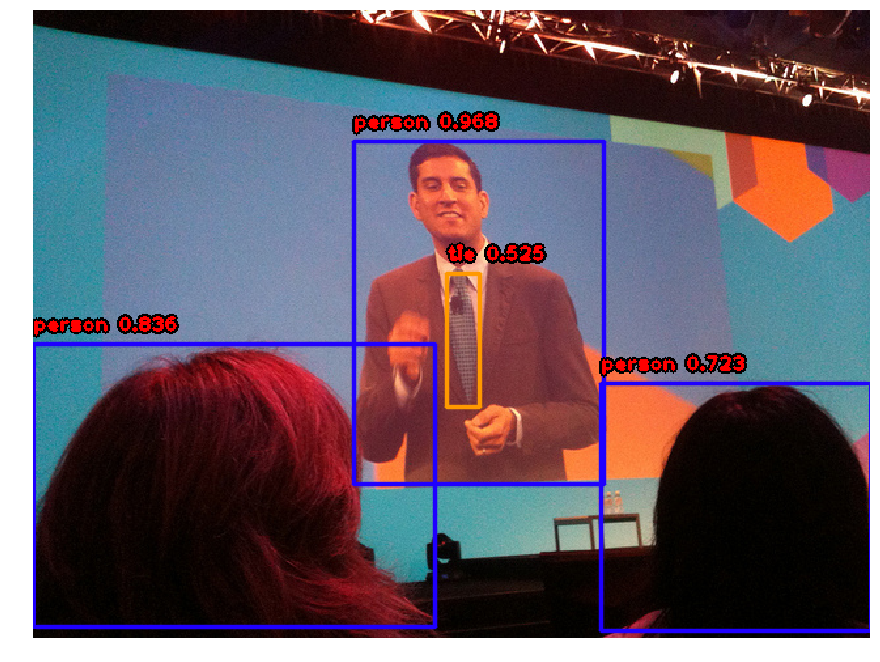

In [6]:
# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption_mine(draw, b, caption)

    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

# Reading in a football scene


In [7]:
cap = cv2.VideoCapture('/data/soccer_video/filmrole1.avi')

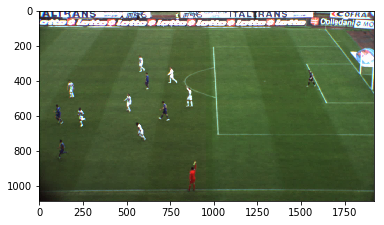

In [8]:
ret, draw = cap.read()
bgr = cv2.cvtColor(draw, cv2.COLOR_RGB2BGR)
plt.imshow(bgr)

In [9]:
image = preprocess_image(bgr)
image, scale = resize_image(image)
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

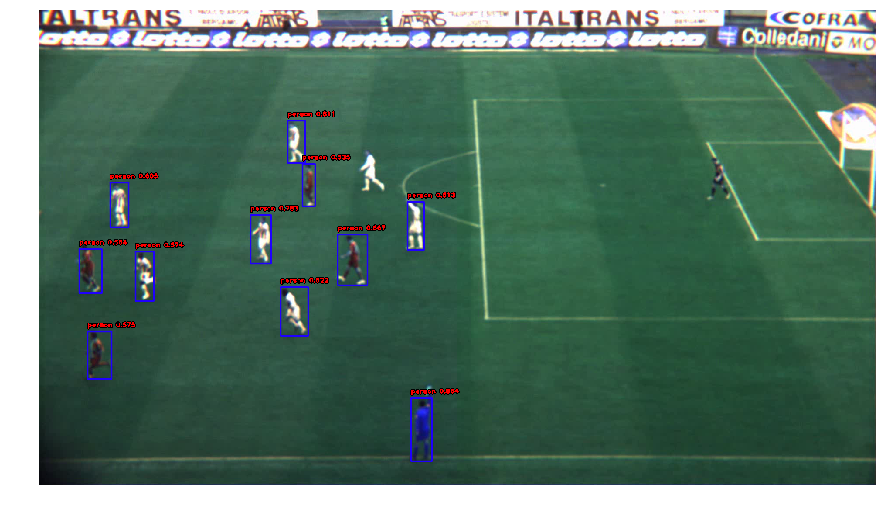

In [10]:
# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption_mine(draw, b, caption)

    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()